In [1]:
import numpy as np
import matplotlib.pyplot as plt
from toksearch_d3d import PtDataSignal

  The MDSplus python module version (HEAD_release_7.139.59) does not match
  the version of the installed MDSplus libraries (unknown_release_0.0.0).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python.


#### Load pre-defined targets

In [2]:
import os
from pathlib import Path

# os.environ["HOME"]

base = Path(os.path.join(os.environ["HOME"], "rl_prof_control_exp/jan_26_exp/selected_targets"))
num_total_targets = 20

rot_rows = []
dens_rows = []
etemp_rows = []
pres_rows = []

for i in range(num_total_targets):
    path = base / f"reference_profile_{i}.txt"
    data = np.loadtxt(path, skiprows=2)  # 4 rows x 33 cols
    rot_rows.append(data[0])
    dens_rows.append(data[1])
    etemp_rows.append(data[2])
    pres_rows.append(data[3])

rot_targets = np.stack(rot_rows)    # shape (num_total_targets, 33)
dens_targets = np.stack(dens_rows)  # shape (num_total_targets, 33)
etemp_targets = np.stack(etemp_rows)
pres_targets = np.stack(pres_rows)

rot_targets.shape, dens_targets.shape, etemp_targets.shape, pres_targets.shape

((20, 33), (20, 33), (20, 33), (20, 33))

#### Helper functions

In [3]:
def big_print(text, size=24):
    from IPython.display import display, HTML
    display(HTML(f"<div style='font-size:{size}px'>{text}</div>"))

def filter_lp(x, prev_y, dt, tau):
    """
    Low-pass filter function.
    
    Args:
        x: Current input value
        prev_y: Previous filtered output value
        dt: Time step
        tau: Time constant (filter strength)
    
    Returns:
        Filtered output value
    """
    return prev_y + dt / (dt + tau) * (x - prev_y)

def apply_lp_filter(data, dt, tau):
    """
    Apply low-pass filter to an array of data.
    
    Args:
        data: Input data array
        dt: Time step (or can be an array of time differences)
        tau: Time constant (controls filter strength)
    
    Returns:
        Filtered data array
    """
    filtered = np.zeros_like(data)
    filtered[0] = data[0]  # Initialize with first value
    
    for i in range(1, len(data)):
        filtered[i] = filter_lp(data[i], filtered[i-1], dt, tau)
    
    return filtered




In [4]:
def interp_full(psi_in, values_in, psi_out):
    """
    Full interpolation function that interpolates from (psi_in, values_in) to psi_out.
    
    Args:
        psi_in: Input psi coordinates (array)
        values_in: Input values at psi_in coordinates (array)
        psi_out: Output psi coordinates where interpolation is desired (array)
    
    Returns:
        Interpolated values at psi_out coordinates
    """
    in_size = len(psi_in)
    out_size = len(psi_out)
    out = np.zeros(out_size)
    
    # Find min and max indices
    j_min = [0, 0]
    j_max = [0, 0]
    
    # Find absolute min and max
    j_min[0] = np.argmin(psi_in)
    j_max[0] = np.argmax(psi_in)
    
    # Find second smallest and second largest
    j_min[1] = j_max[0]
    j_max[1] = j_min[0]
    
    for j in range(in_size):
        if psi_in[j] > psi_in[j_min[0]] and psi_in[j] <= psi_in[j_min[1]]:
            j_min[1] = j
        if psi_in[j] < psi_in[j_max[0]] and psi_in[j] >= psi_in[j_max[1]]:
            j_max[1] = j
    
    # Interpolate for each output point
    for i in range(out_size):
        psi_t = psi_out[i]
        j_high = j_max[0]
        j_low = j_min[0]
        
        # Find bracketing indices
        for j in range(in_size):
            if psi_in[j] > psi_t and psi_in[j] < psi_in[j_high]:
                j_high = j
            elif psi_in[j] < psi_t and psi_in[j] > psi_in[j_low]:
                j_low = j
        
        # Handle extrapolation at boundaries
        if j_high == j_max[0]:
            j_low = j_max[1]
        elif j_low == j_min[0]:
            j_high = j_min[1]
        
        # Linear interpolation
        out_high = values_in[j_high]
        out_low = values_in[j_low]
        psi_n_diff = psi_in[j_high] - psi_in[j_low]
        weight = (psi_t - psi_in[j_low]) / psi_n_diff if abs(psi_n_diff) >= 1e-5 else 0.0
        out[i] = out_low + weight * (out_high - out_low)
    
    return out


def interp_profile(values_in, out_size):
    """
    Interpolate profile from input size to output size using uniform psi grid.
    
    Args:
        values_in: Input profile values (array of length in_size)
        out_size: Desired output size (e.g., 33)
    
    Returns:
        Interpolated profile of length out_size
    """
    in_size = len(values_in)
    
    # Create uniform psi grids
    psi_in = np.linspace(0, 1, in_size)
    psi_out = np.linspace(0, 1, out_size)
    
    return interp_full(psi_in, values_in, psi_out)


def convert_profiles_101_to_33(profiles_101):
    """
    Convert profiles from 101 dimensions to 33 dimensions.
    
    Args:
        profiles_101: Array of shape (..., 101) with profiles to convert
    
    Returns:
        Array of shape (..., 33) with interpolated profiles
    """
    original_shape = profiles_101.shape
    
    # Reshape to (N, 101) where N is product of all dimensions except last
    profiles_flat = profiles_101.reshape(-1, original_shape[-1])
    
    # Interpolate each profile
    profiles_33 = np.array([interp_profile(prof, 33) for prof in profiles_flat])
    
    # Reshape back to original dimensions with 33 instead of 101
    new_shape = original_shape[:-1] + (33,)
    return profiles_33.reshape(new_shape)

#### Step 1. Performance analysis
# // Set meta parameters

In [38]:
shot = 203022
prof_type = 'rot'  # ['rot', 'dens', 'pres', 'etemp']
selected_target_idxs = [12, 17, 12]  # idices of selected targets
targets_set_time = [2000, 3000, 4000, 5000]  # [start flattop time/target1 start_t, target2 start_t, target3 start_t, end flattop time]
rad_idxs_to_analyze = [0, 5, 10, 15, 20, 25, 30]  # radius positions to examine

In [39]:
assert len(selected_target_idxs) == len(targets_set_time) - 1, "Number of target indices must be one less than number of target set times."
assert prof_type in ['rot', 'dens', 'pres', 'etemp'], "Profile type must be one of ['rot', 'dens', 'pres', 'etemp']."
print("================= Metadata =================")
print(f"Shot ID: {shot}")
print(f"Profile for analysis: {prof_type}")
print(f"Raidus indices to analyze: {len(rad_idxs_to_analyze)} positions: {rad_idxs_to_analyze}")
for i in range(len(selected_target_idxs)):
    print(f"Target {i+1}: index {selected_target_idxs[i]}, effective from {targets_set_time[i]} to {targets_set_time[i+1]} ms")
print("============================================")

if prof_type == 'rot':
    all_targets = rot_targets
elif prof_type == 'dens':
    all_targets = dens_targets
elif prof_type == 'etemp':
    all_targets = etemp_targets
elif prof_type == 'pres':
    all_targets = pres_targets

================= Metadata =================
Shot ID: 203022
Profile for analysis: rot
Raidus indices to analyze: 7 positions: [0, 5, 10, 15, 20, 25, 30]
Target 1: index 12, effective from 2000 to 3000 ms
Target 2: index 17, effective from 3000 to 4000 ms
Target 3: index 12, effective from 4000 to 5000 ms


#### Visualize targets

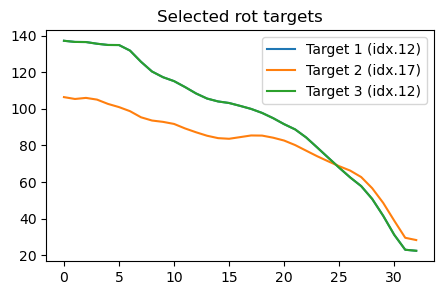

In [40]:
plt.figure(figsize=(5, 3))
for i in range(len(selected_target_idxs)):
    plt.plot(all_targets[selected_target_idxs[i]], label=f"Target {i+1} (idx.{selected_target_idxs[i]})")
plt.title(f"Selected {prof_type} targets")
plt.legend()
plt.show()

#### Pull RTCAKENN data

In [41]:
x = PtDataSignal('CKXOUT').fetch(shot)
times = x['times']
data = x['data']
NYMODEL = 2
NYOUT_PTS = 101
NYPROF = 7
prof_data = data.reshape((-1, NYMODEL, NYOUT_PTS, NYPROF))
dens_profiles = prof_data[:, 1, :, 3]  # 3-- for density || 6 for rotation
rot_profiles = prof_data[:, 1, :, 6]
# q_profiles = prof_data[:, 1, :, 2]
pres_profiles = prof_data[:, 1, :, 0]
etemp_profiles = prof_data[:, 1, :, 4]

# down-sampling
dens_profiles_33 = convert_profiles_101_to_33(dens_profiles)
rot_profiles_33 = convert_profiles_101_to_33(rot_profiles)
# q_profiles_33 = convert_profiles_101_to_33(q_profiles)
pres_profiles_33 = convert_profiles_101_to_33(pres_profiles)
etemp_profiles_33 = convert_profiles_101_to_33(etemp_profiles)

#smoothening with low-pass filter
rot_profiles_33 = apply_lp_filter(rot_profiles_33, dt=20.0, tau=50.0)
dens_profiles_33 = apply_lp_filter(dens_profiles_33, dt=20.0, tau=50.0)
pres_profiles_33 = apply_lp_filter(pres_profiles_33, dt=20.0, tau=50.0)
etemp_profiles_33 = apply_lp_filter(etemp_profiles_33, dt=20.0, tau=50.0)

dens_profiles_33.shape, rot_profiles_33.shape, pres_profiles_33.shape, etemp_profiles_33.shape

if prof_type == 'rot':
    profile_signals = rot_profiles_33
elif prof_type == 'dens':
    profile_signals = dens_profiles_33
elif prof_type == 'pres':
    profile_signals = pres_profiles_33
elif prof_type == 'etemp':
    profile_signals = etemp_profiles_33

Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.


#### Comparing data and targets

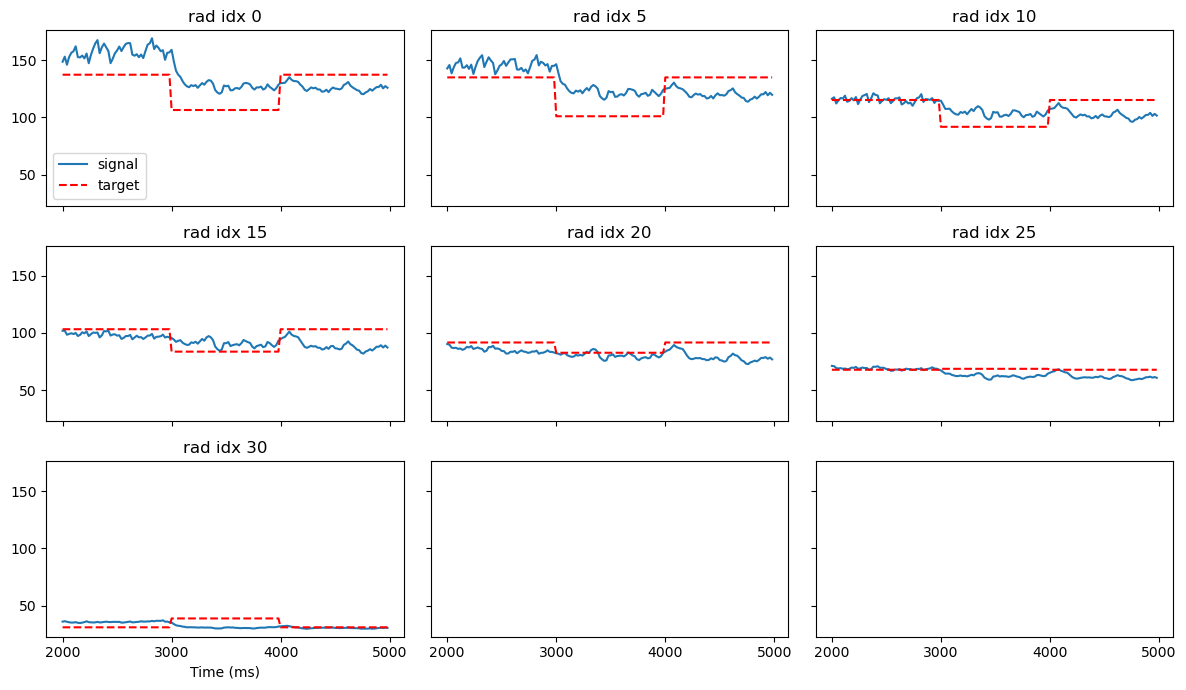

In [42]:
num_set_targets = len(selected_target_idxs)
set_time_idxs = [np.argmin(np.abs(times - t)) for t in targets_set_time]
fig, axes = plt.subplots(3, 3, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(len(rad_idxs_to_analyze)):
    axes[i].plot(profile_signals[set_time_idxs[0]:set_time_idxs[-1], rad_idxs_to_analyze[i]], label='signal')
    yi = np.empty((set_time_idxs[-1] - set_time_idxs[0]), dtype=float)
    start_idx = 0
    for j in range(num_set_targets):
        yi[start_idx:set_time_idxs[j+1] - set_time_idxs[0]] = all_targets[selected_target_idxs[j], rad_idxs_to_analyze[i]]
        start_idx = set_time_idxs[j+1] - set_time_idxs[0]
    axes[i].plot(yi, label='target', linestyle='--', color='r')
    axes[i].set_title(f"rad idx {rad_idxs_to_analyze[i]}")
    if i == 0:
        axes[i].legend()
axes[6].set_xticks(np.arange(0, set_time_idxs[-1] - set_time_idxs[0]+1, 50), 
                   labels=[str(t) for t in np.arange(targets_set_time[0], targets_set_time[-1]+1, 50 * 20)])
axes[6].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

# // Set reference time and num candidates to visualize

In [10]:
ref_time = 1800

#### Step 3. Targets selection

In [29]:
ref_time_idx = np.argmin(np.abs(times - ref_time))  # find the index closest to ref_time
prof33_at_ref_time = convert_profiles_101_to_33(profile_signals[ref_time_idx, :])

# Get three target index so that prof33_at_ref_time is closest to the target
n_candidates = 3
diffs = np.linalg.norm(all_targets - prof33_at_ref_time, axis=1)
ref_target_candidates_idxs = np.argsort(diffs)[:n_candidates]
big_print(f"Candidates for ref target indices: {ref_target_candidates_idxs.tolist()}", size=20)

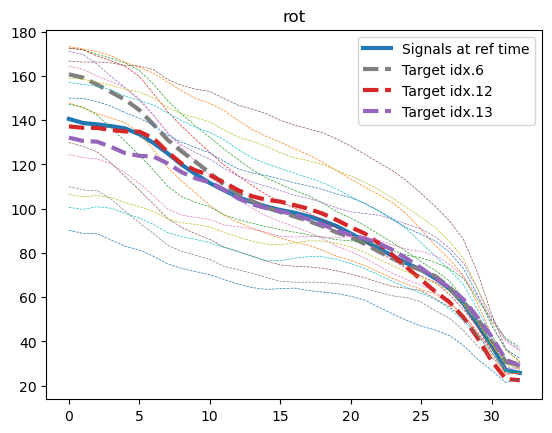

In [30]:
plt.plot(prof33_at_ref_time, label='Signals at ref time', linewidth=3)
for i in range(num_total_targets):
    if i in ref_target_candidates_idxs:
        plt.plot(all_targets[i, :], label=f'Target idx.{i}', linestyle='--', linewidth=3)
    else:
        plt.plot(all_targets[i, :], linestyle='--', linewidth=.5)
plt.title(f'{prof_type}')
plt.legend()
plt.show()

# // Set ref target idx (Target1 of next shot)

In [31]:
selected_ref_target_idx = 12

#### Candidates for upper targets

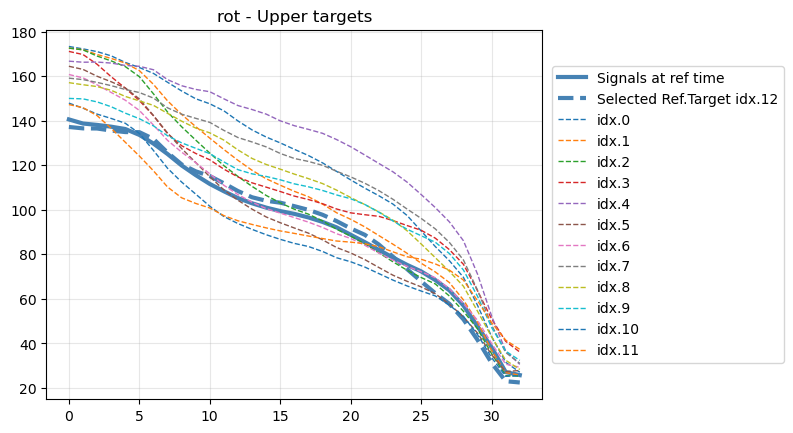

In [32]:
plt.plot(prof33_at_ref_time, label='Signals at ref time', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_ref_target_idx, :], label=f'Selected Ref.Target idx.{selected_ref_target_idx}', linestyle='--', linewidth=3, color='steelblue')
for i in range(selected_ref_target_idx):
    plt.plot(all_targets[i, :], linestyle='--', linewidth=1, label=f'idx.{i}')
plt.title(f'{prof_type} - Upper targets')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.grid(alpha=0.3)
plt.show()

# // Set upper target index (Target2 for next shot)

In [33]:
selected_upper_target_idx = 9

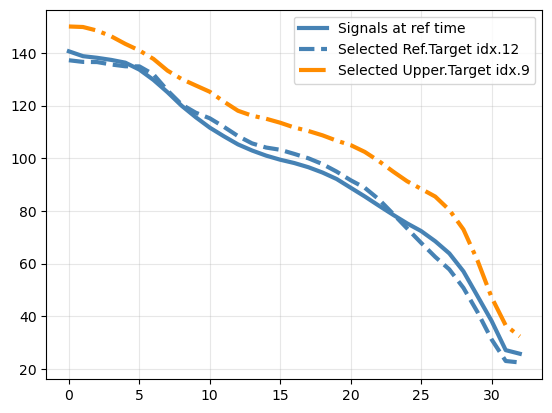

In [34]:
plt.plot(prof33_at_ref_time, label='Signals at ref time', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_ref_target_idx, :], label=f'Selected Ref.Target idx.{selected_ref_target_idx}', linestyle='--', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_upper_target_idx, :], label=f'Selected Upper.Target idx.{selected_upper_target_idx}', linestyle='-.', linewidth=3, color='darkorange')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Candidates for lower targets

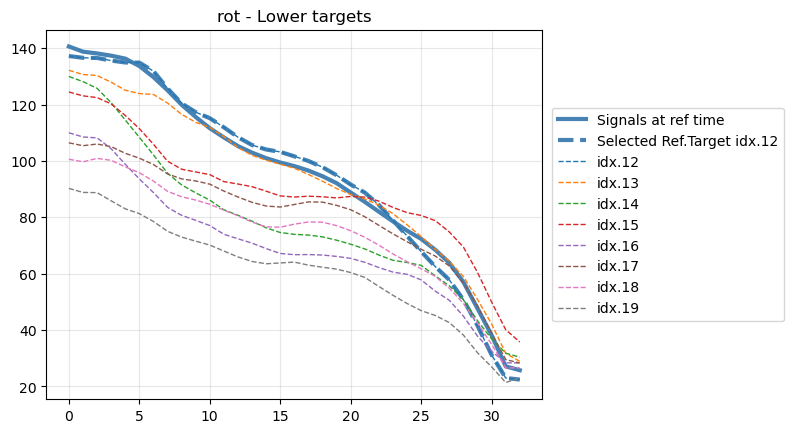

In [35]:
plt.plot(prof33_at_ref_time, label='Signals at ref time', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_ref_target_idx, :], label=f'Selected Ref.Target idx.{selected_ref_target_idx}', linestyle='--', linewidth=3, color='steelblue')
for i in range(selected_ref_target_idx, num_total_targets):
    plt.plot(all_targets[i, :], linestyle='--', linewidth=1, label=f'idx.{i}')
plt.title(f'{prof_type} - Lower targets')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.grid(alpha=0.3)
plt.show()

# // Set lower target index (Target3 for next shot)

In [36]:
selected_lower_target_idx = 17

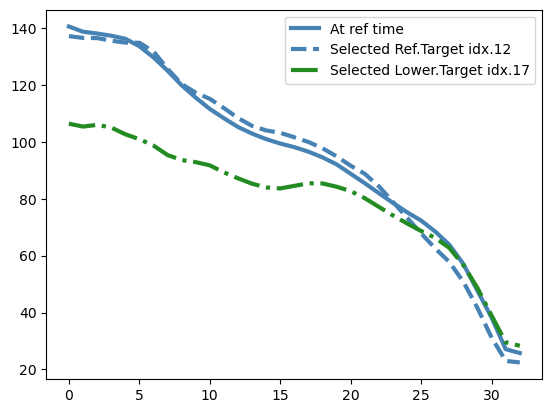

In [37]:
plt.plot(prof33_at_ref_time, label='At ref time', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_ref_target_idx, :], label=f'Selected Ref.Target idx.{selected_ref_target_idx}', linestyle='--', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_lower_target_idx, :], label=f'Selected Lower.Target idx.{selected_lower_target_idx}', linestyle='-.', linewidth=3, color='forestgreen')
plt.legend()
plt.show()

# Summary

In [35]:
print("================= Target selection =================")
print(f"Shot ID: {shot}")
print(f"Profile: {prof_type}")
print(f"Taget 1: index {selected_ref_target_idx}, effective from {targets_set_time[0]} to {targets_set_time[1]} ms")
print(f"Taget 2: index {selected_upper_target_idx}, effective from {targets_set_time[1]} to {targets_set_time[2]} ms")
print(f"Taget 3: index {selected_lower_target_idx}, effective from {targets_set_time[2]} to {targets_set_time[3]} ms")
print("====================================================")

================= Target selection =================
Shot ID: 203018
Profile: rot
Taget 1: index 12, effective from 2000 to 3000 ms
Taget 2: index 9, effective from 3000 to 4000 ms
Taget 3: index 17, effective from 4000 to 5000 ms


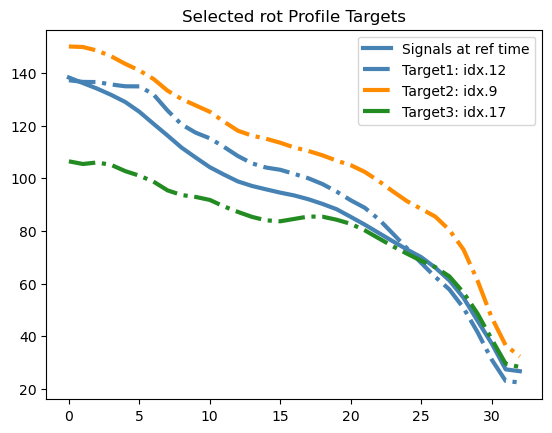

In [36]:
plt.plot(prof33_at_ref_time, label='Signals at ref time', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_ref_target_idx, :], label=f'Target1: idx.{selected_ref_target_idx}', linestyle='-.', linewidth=3, color='steelblue')
plt.plot(all_targets[selected_upper_target_idx, :], label=f'Target2: idx.{selected_upper_target_idx}', linestyle='-.', linewidth=3, color='darkorange')
plt.plot(all_targets[selected_lower_target_idx, :], label=f'Target3: idx.{selected_lower_target_idx}', linestyle='-.', linewidth=3, color='forestgreen')
plt.title(f'Selected {prof_type} Profile Targets')
plt.legend()
plt.show()